# Core Plotting Functions

This tutorial will rely on a dataset from 10X originally containing 68k cells from PBMCs. A preprocessed and reduced sample of this dataset (containing 700 cells and 765 highly variable genes) is available through the scanpy package.

We will also rely on the following marker genes from literature:

- **B-cell**: CD79A, MS4A1
- **T-cell**: CD3D
- **NK**: GNLY, NKG7
- **Myeloid**: CST3, LYZ
- **Monocytes**: FCGR3A
- **Dendritic**: FCER1A

## Scatter plots for embeddings

Scanpy allows easy plotting of embeddings such as tSNE and UMAP (and others) using functions like `sc.pl.tsne`, `sc.pl.umap`, etc.

The umap plotting function access information in `adata.obsm['X_umap']`. For more flexibility, any key stored in `adata.obsm` can be used with the generic embedding function `sc.pl.embedding`.

In [50]:
import scanpy as sc
import pandas as pd
from matplotlib import rcParams

In [51]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


### Load pbmc dataset

In [52]:
pbmc = sc.datasets.pbmc68k_reduced()

In [53]:
pbmc

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Visualization of Gene Expression and Other  Variables

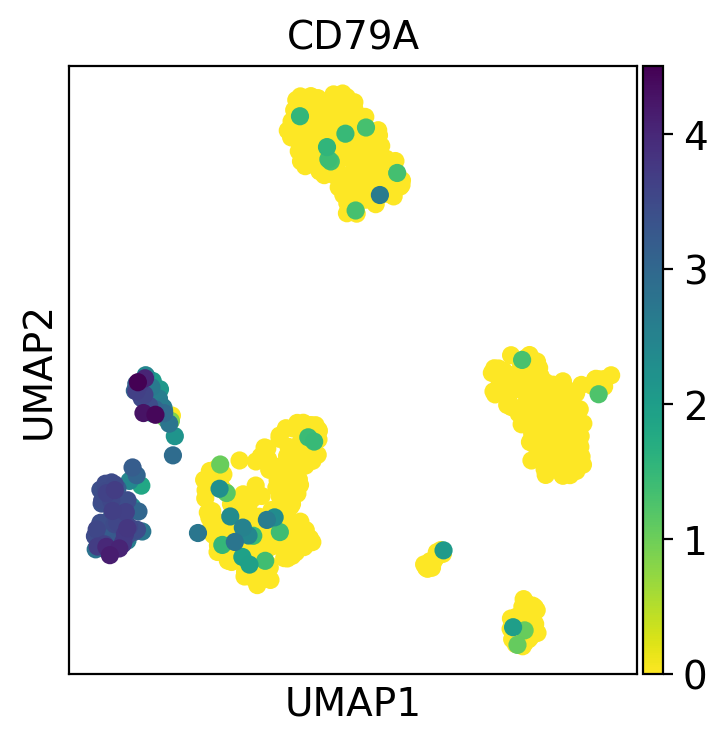

In [54]:
#rcParams is used for the figure size, in this case 4x4
rcParams['figure.figsize'] = 4,4
sc.pl.umap(pbmc, color='CD79A') #looking at a B-cell marker

Let's look at more genes as well as `n_counts` which is the number of UMI counts per cell, and `bulk_lables` which is a categorical value with the original labelling of cells from 10X.

Set number of plots per row using `ncols` parameter. The maximum value being plotted can be adjusted with `vmax` or similiarly `vmin`.  Here we use `p99` which sets the max value to the 99th pecetile. Finally, we use `frameon=False` to remove the boxes around the plots and `s=50` to set the dot size.

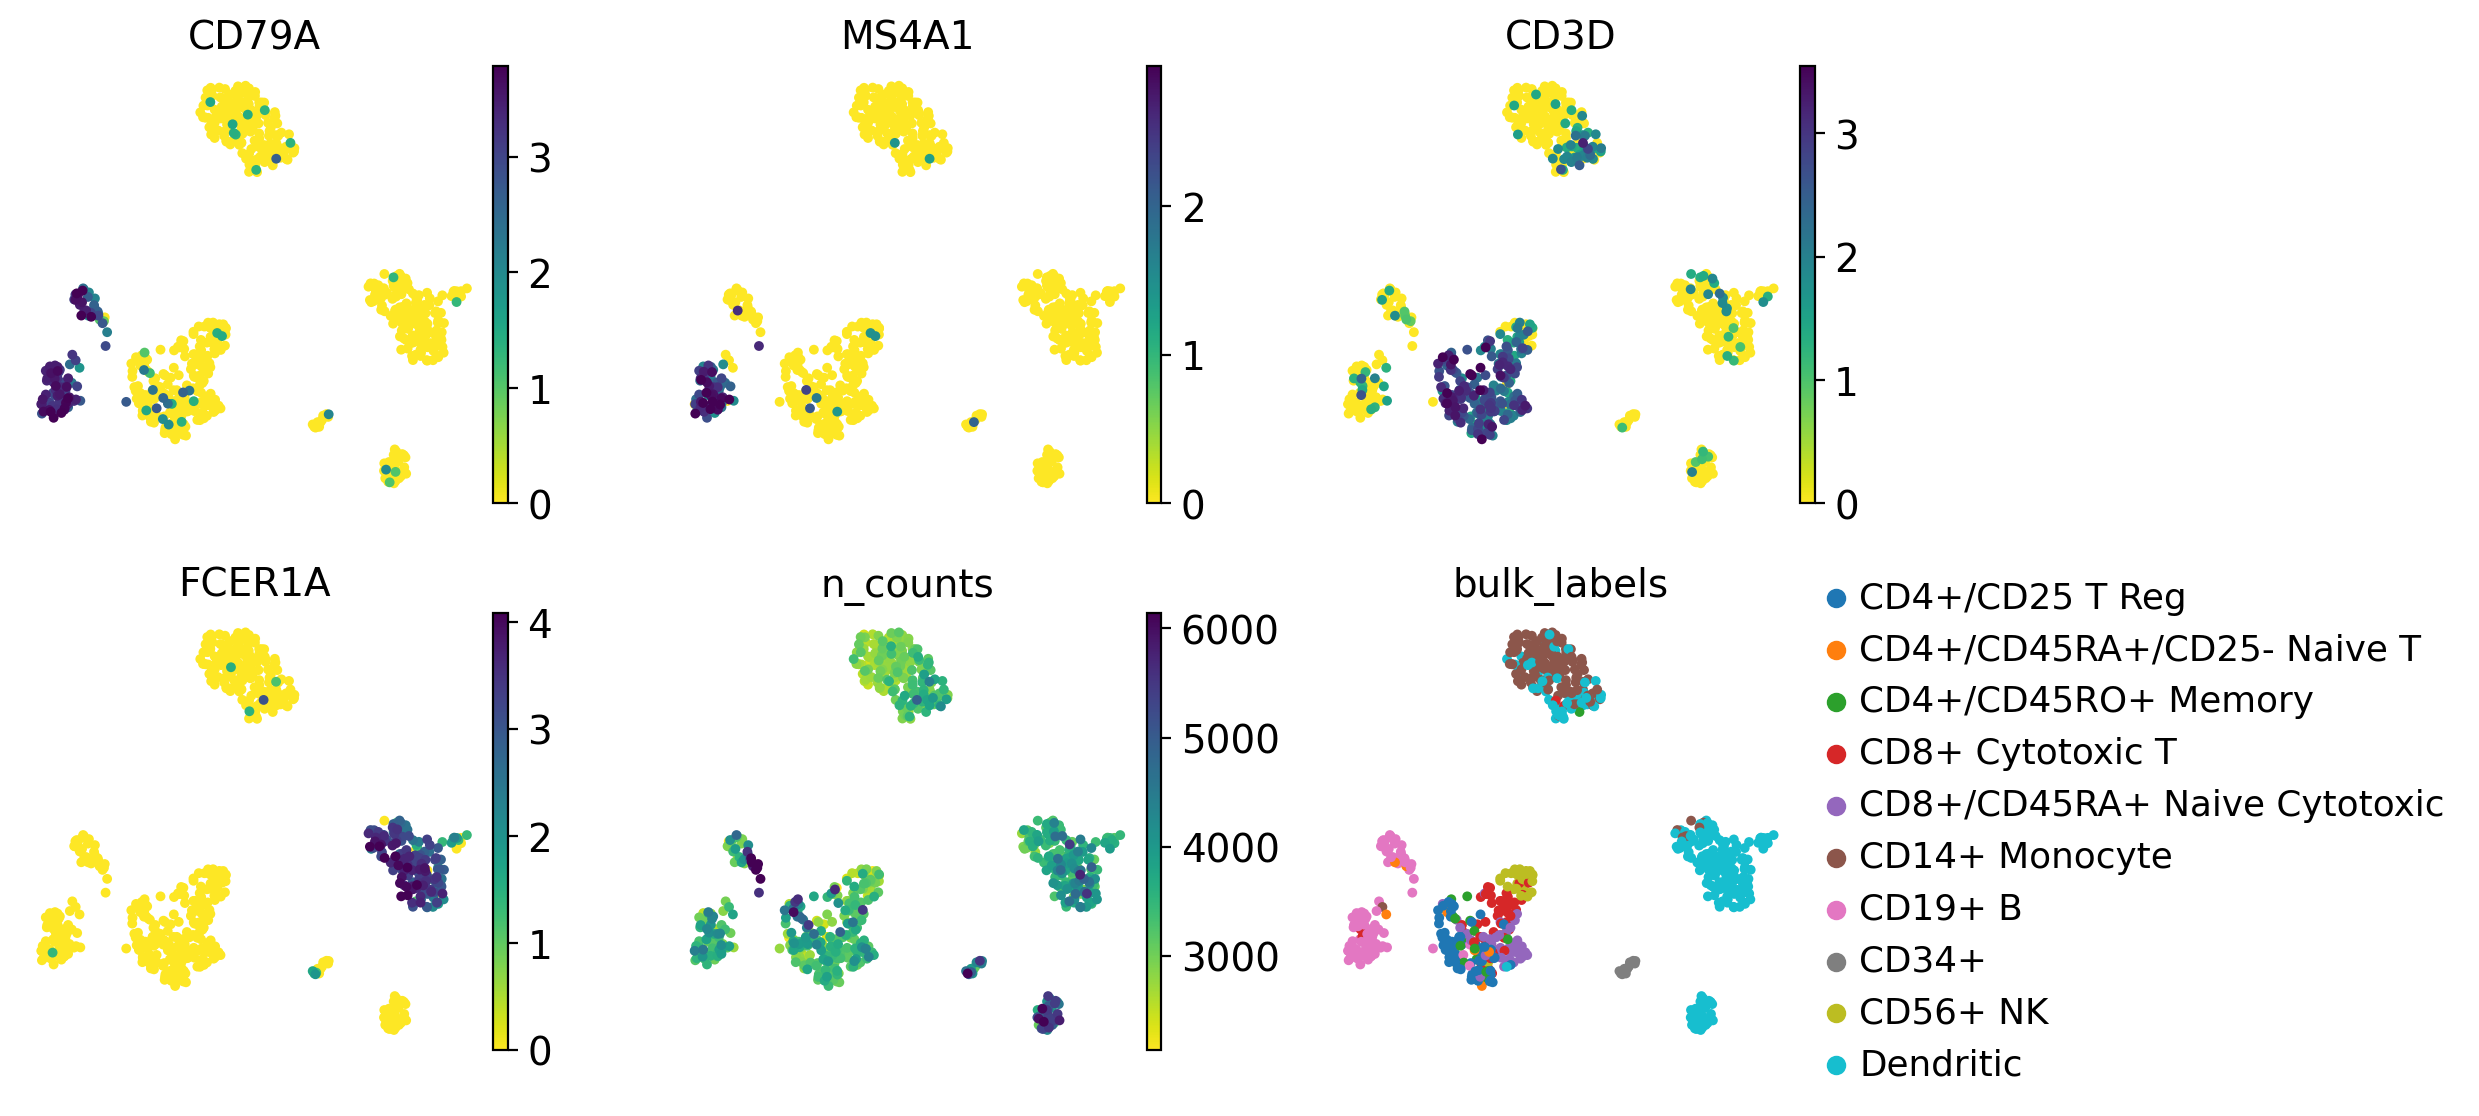

In [55]:
rcParams['figure.figsize'] = 3,3
sc.pl.umap(pbmc, color=['CD79A', 'MS4A1', 'CD3D', 'FCER1A', 'n_counts', 'bulk_labels'], s=50, frameon=False, ncols=3, vmax='p99')
#markers are B cell, B cell, T cell, DC

It appears the markers match the original annotations for the most part. That's good.

Now let's do some clustering using the Leiden method.

In [56]:
sc.tl.leiden(pbmc, key_added='clusters', resolution=0.5)

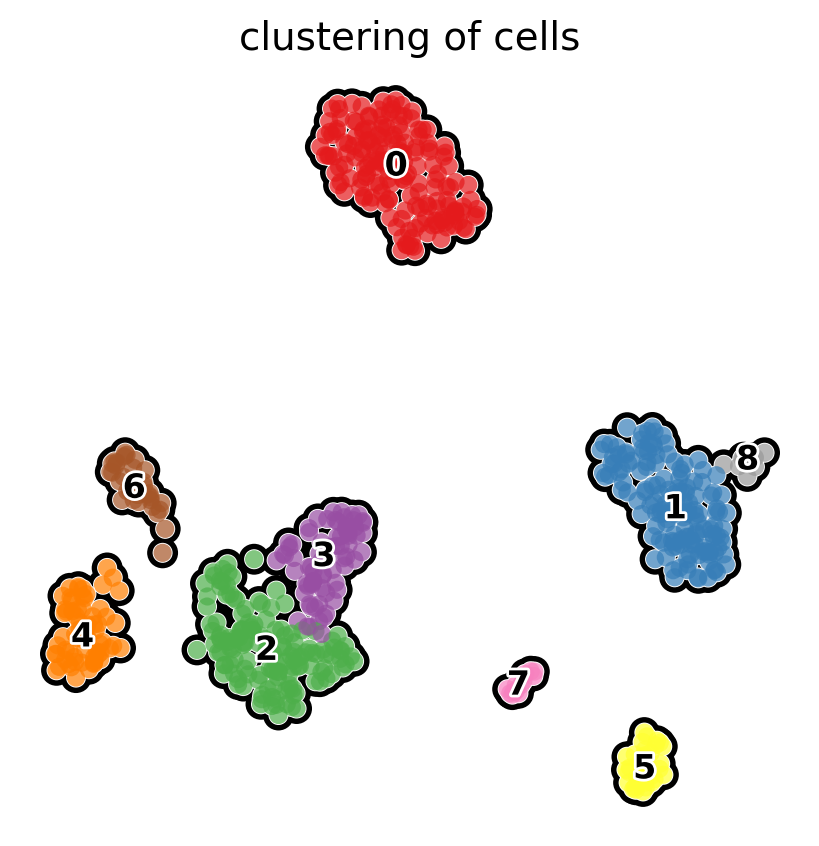

In [57]:
rcParams['figure.figsize']= 5,5
sc.pl.umap(pbmc, color='clusters', add_outline=True, legend_loc='on data',
          legend_fontsize=12, legend_fontoutline=2, frameon=False,
          title='clustering of cells', palette='Set1')

## Identification of Clusters Based on Known Marker Genes

In [58]:
marker_genes_dict = {'NK': ['GNLY', 'NKG7'],
                     'T-cell': ['CD3D'],
                     'B-cell': ['CD79A', 'MS4A1'],
                     'Monocytes': ['FCGR3A'],
                     'Dendritic': ['FCER1A']}

#### dotplot

Let's use a dotplot to visualize the expression of these marker genes in the 9 leiden clusters we found above.

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


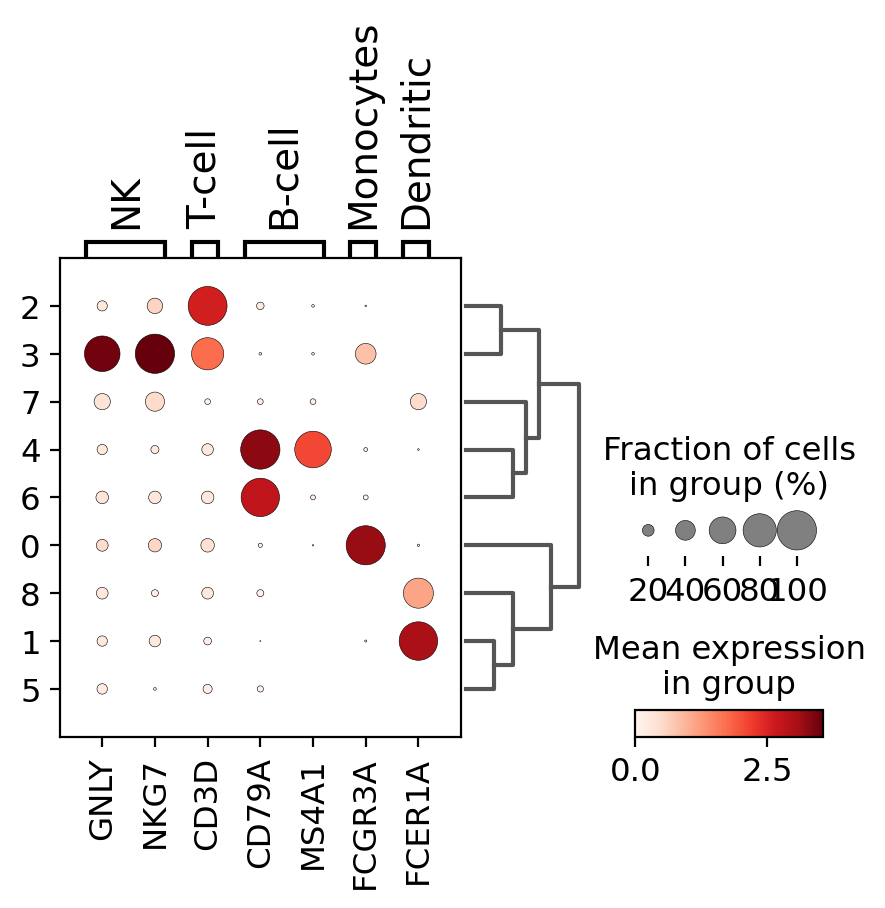

In [59]:
sc.pl.dotplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True)

Based on the information from the dotplot, we can manually annotate the clusters. The ones in the tutorial don't make sense so I will be redoing them.

In [60]:
cluster2annotation = {
     '0': 'Monocyte',
     '1': 'Dendritic',
     '2': 'T-cell',
     '3': 'NK',
     '4': 'B-cell',
     '5': 'other',
     '6': 'B-cell',
     '7': 'other',
     '8': 'Dendritic'
}

pbmc.obs['cell type'] = pbmc.obs['clusters'].map(cluster2annotation).astype('category')

categories: B-cell, Dendritic, Monocyte, etc.
var_group_labels: NK, T-cell, B-cell, etc.


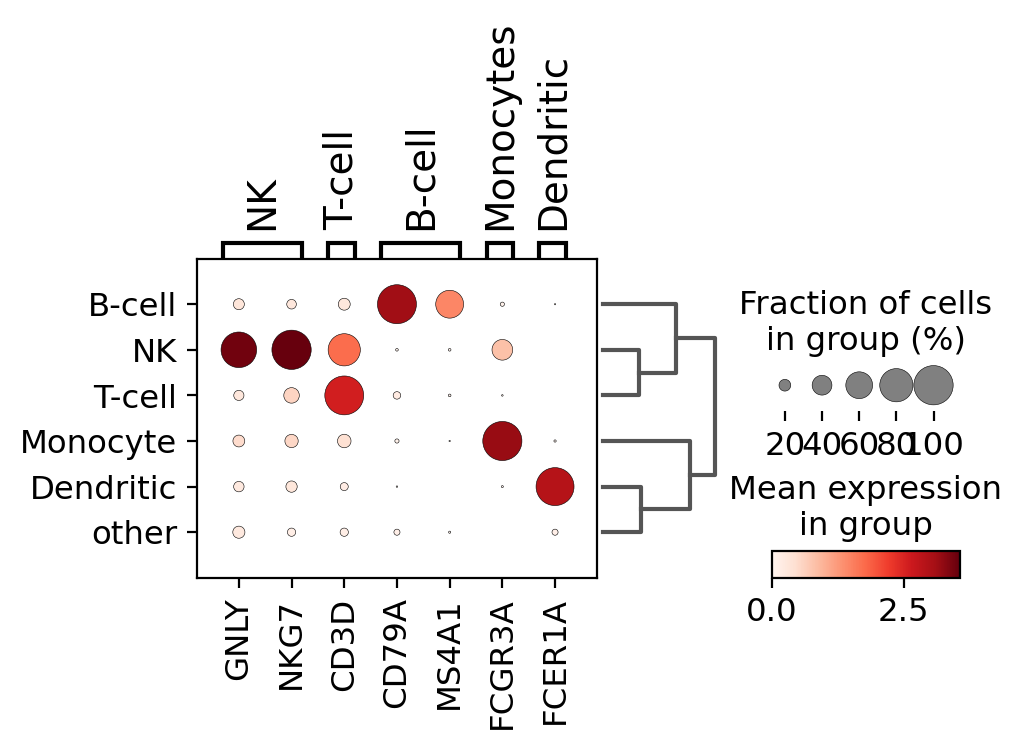

In [72]:
sc.pl.dotplot(pbmc, marker_genes_dict, 'cell type', dendrogram=True)

In [ ]:
sc.pl.umap(pbmc, color = 'cell type', legend_loc='on data',
          frameon=False, legend_fontsize=10)

I'm not super confident in these annotations. It is much different than the tutorial. But my annotations make more sense given the dotplots. In particular, one thing to notice in the tutorial is the existence of a "monocyte" cluster and a different "monocytes" cluster.

### violin plot

We can also look at expression of specific marker genes in each cluster using violin plots.

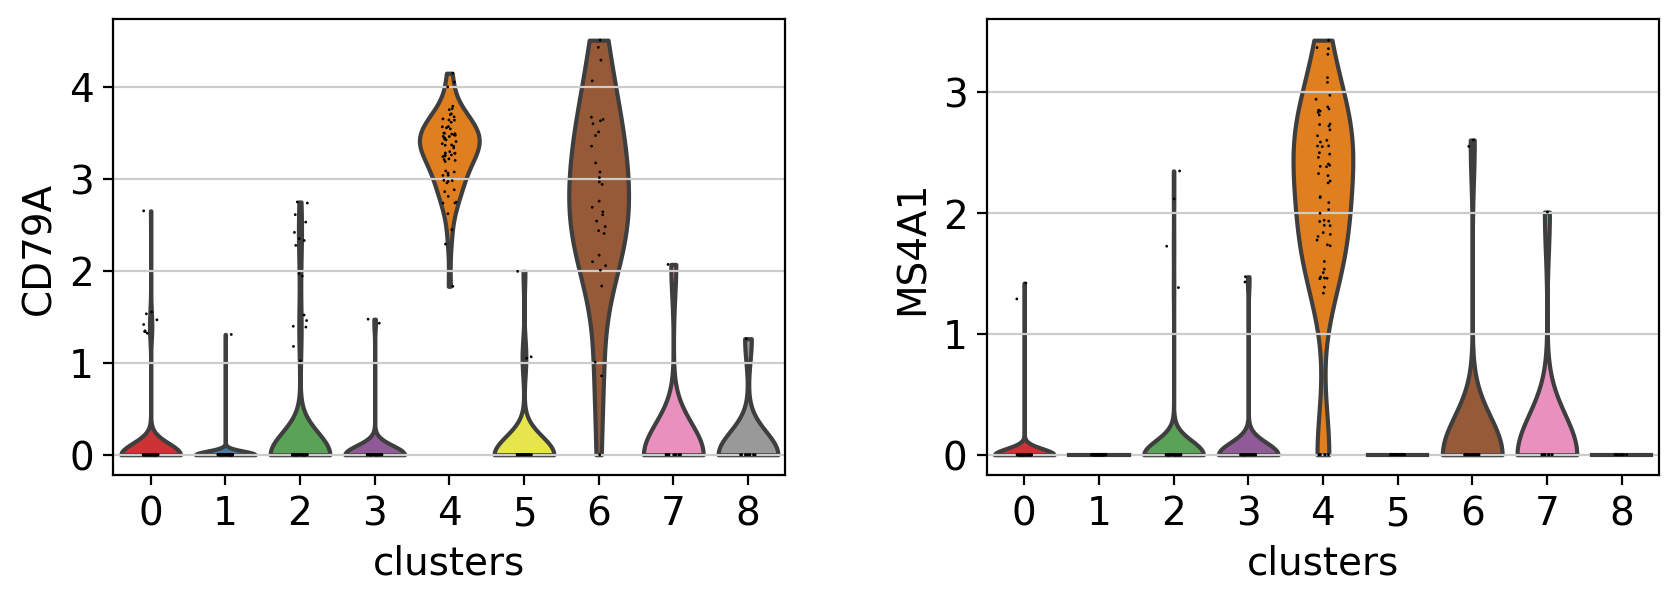

In [62]:
rcParams['figure.figsize'] = 4.5,3
sc.pl.violin(pbmc, ['CD79A', 'MS4A1'], groupby='clusters')

We can look at any numerical observation.

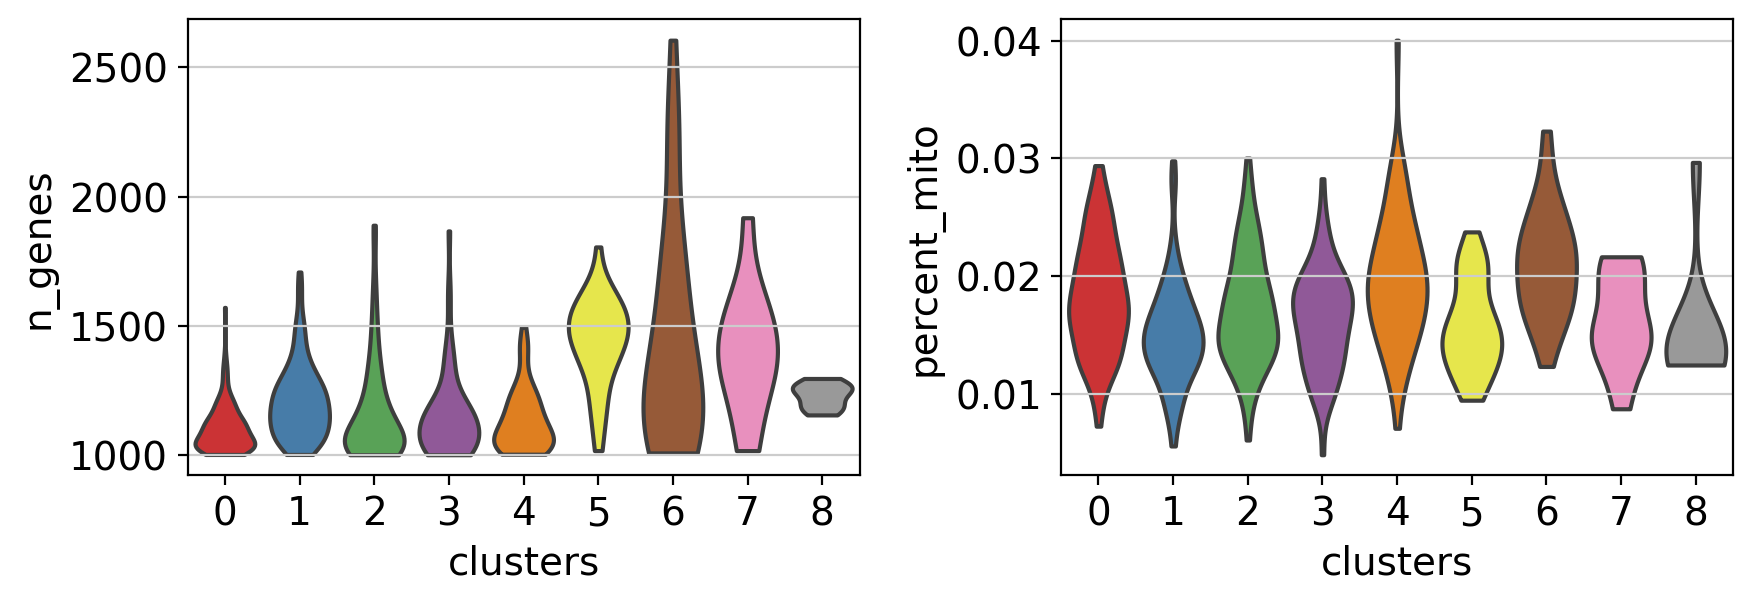

In [63]:
sc.pl.violin(pbmc, ['n_genes', 'percent_mito'], groupby='clusters', stripplot=False) #stripplot=False removes internal dots

### stacked-violin plot

We can do something that is like a dotplot but containing mini violins using a stacked-violin plot

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


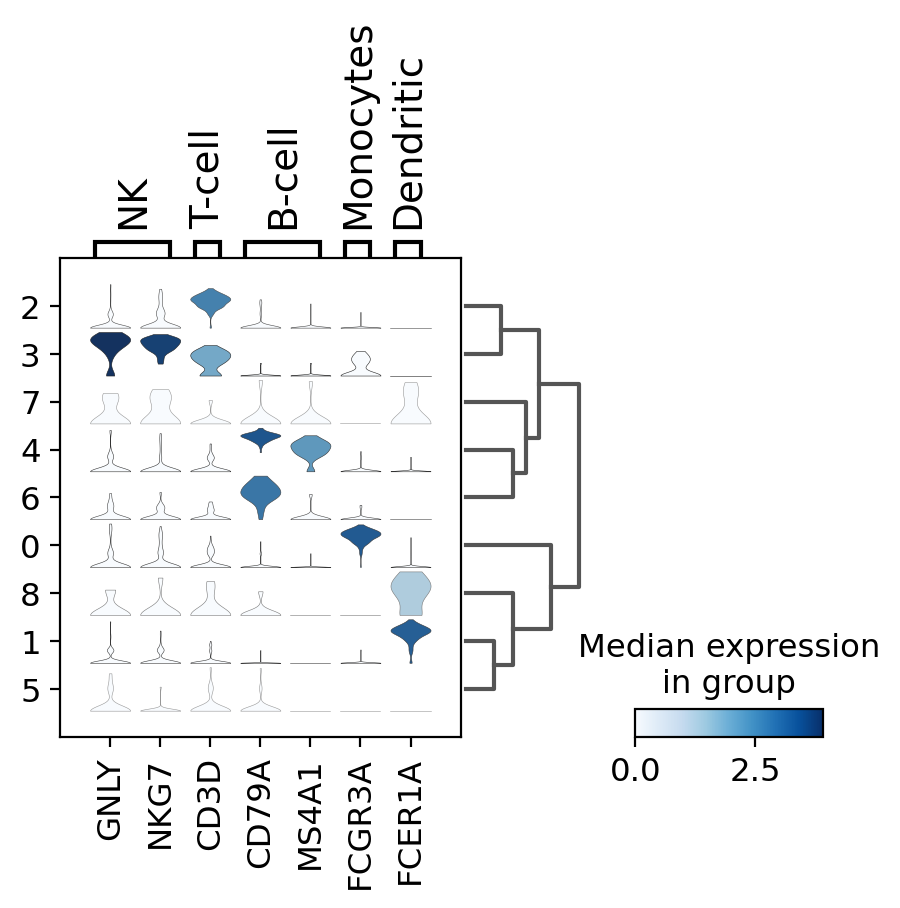

In [64]:
ax = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby='clusters', swap_axes=False, dendrogram=True)

### matrixplot

Finally, we can do something similar but with a matrix plot. This will show gene expression on a scale of 0-1 which correspond to the minimum and maximum meme respectively.

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


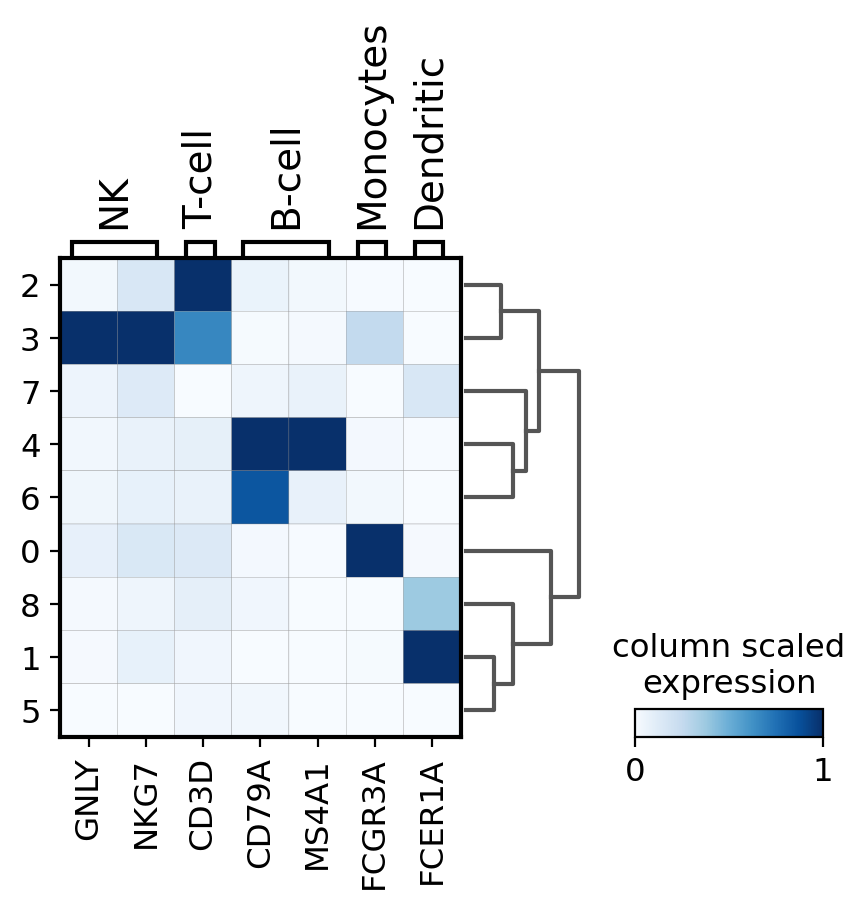

In [65]:
sc.pl.matrixplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True,
                cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

Scaling and normalizing the gene expression data can change how we display the matrix plot with different ranges.

In [66]:
pbmc.layers['scaled'] = sc.pp.scale(pbmc, copy=True).X

categories: 0, 1, 2, etc.
var_group_labels: NK, T-cell, B-cell, etc.


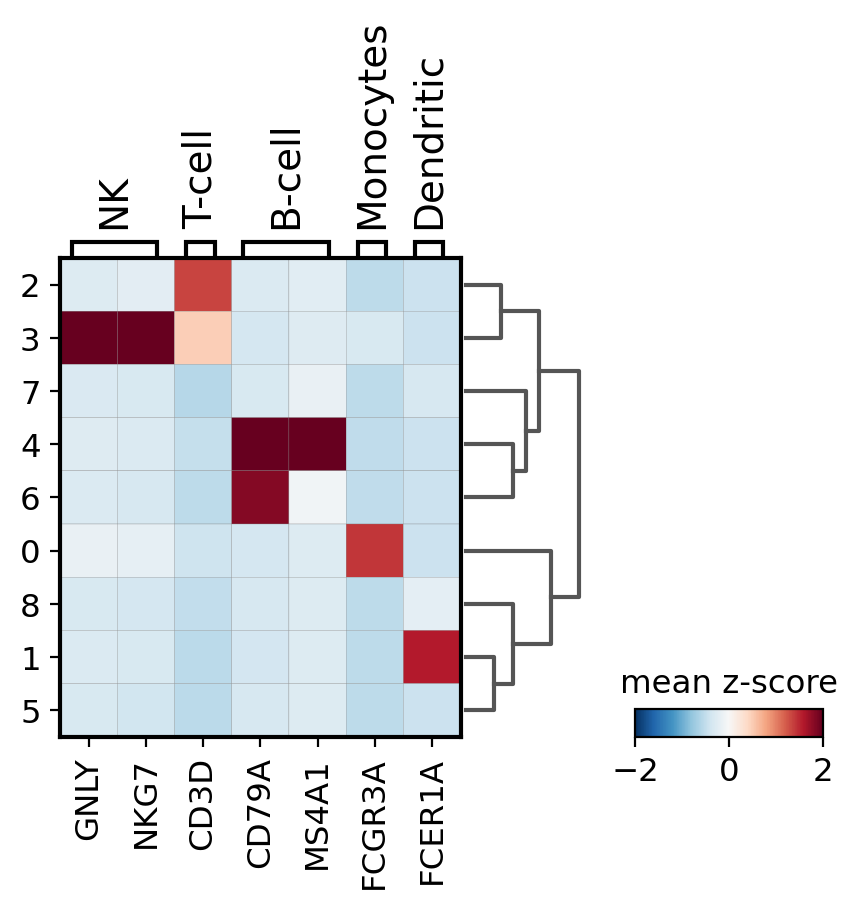

In [73]:
sc.pl.matrixplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True,
                colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

## Combining Plots in Subplots

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.8})
ax1_dict = sc.pl.dotplot(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax1, show=False)
ax2_dict = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax2, show=False)
ax3_dict = sc.pl.matrixplot(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax3, show=False, cmap='viridis')

## Heatmaps

Heatmaps don't collapse the clusters into single points, instead each cell is given its own row and the rows are arranged into the clusters.

In [ ]:
ax = sc.pl.heatmap(pbmc, marker_genes_dict, groupby='clusters', cmap='viridis', dendrogram=True)

We can also show the scaled data, and change the colors to show divergence or expression up or down.

In [ ]:
ax = sc.pl.heatmap(pbmc, marker_genes_dict, groupby='clusters', layer='scaled', 
                   vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=True, swap_axes=True)

## Tracksplot

Similiar to a heatmap, a tracksplot show gene expression as height, not color.

In [ ]:
ax = sc.pl.tracksplot(pbmc, marker_genes_dict, groupby='louvain', dendrogram=True)

## Vizualization of Marker Genes

Instead of characterizing clusters based on known marker genes, we can identify differentially expressed genes in each clusters as markers.

In [68]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [69]:
sc.tl.rank_genes_groups(pbmc, groupby='clusters', n_genes=pbmc.shape[1], method='wilcoxon')

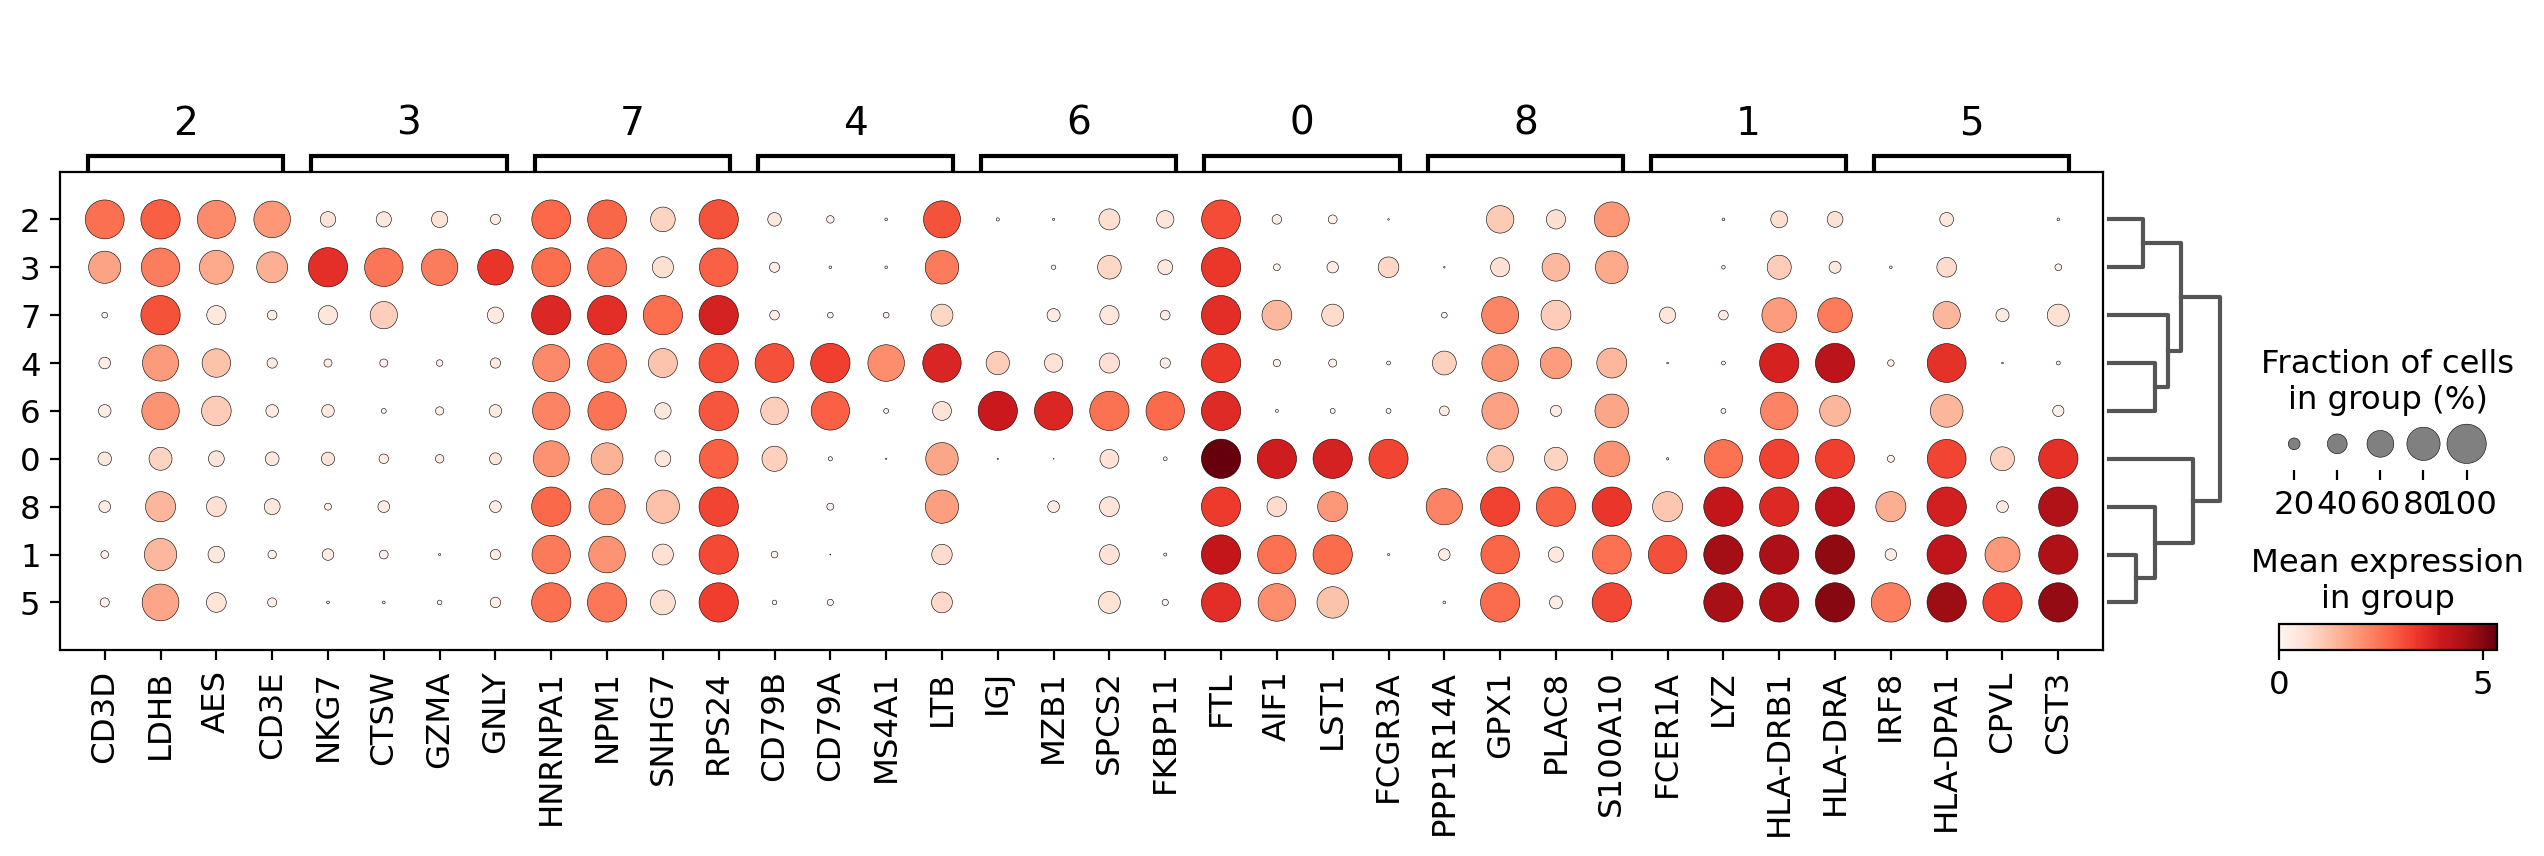

In [70]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4)

We may get a better representation with *log fold changes* instead of gene expression. We can focus on genes with log fold changes >= 3 compared to the rest of the cells.

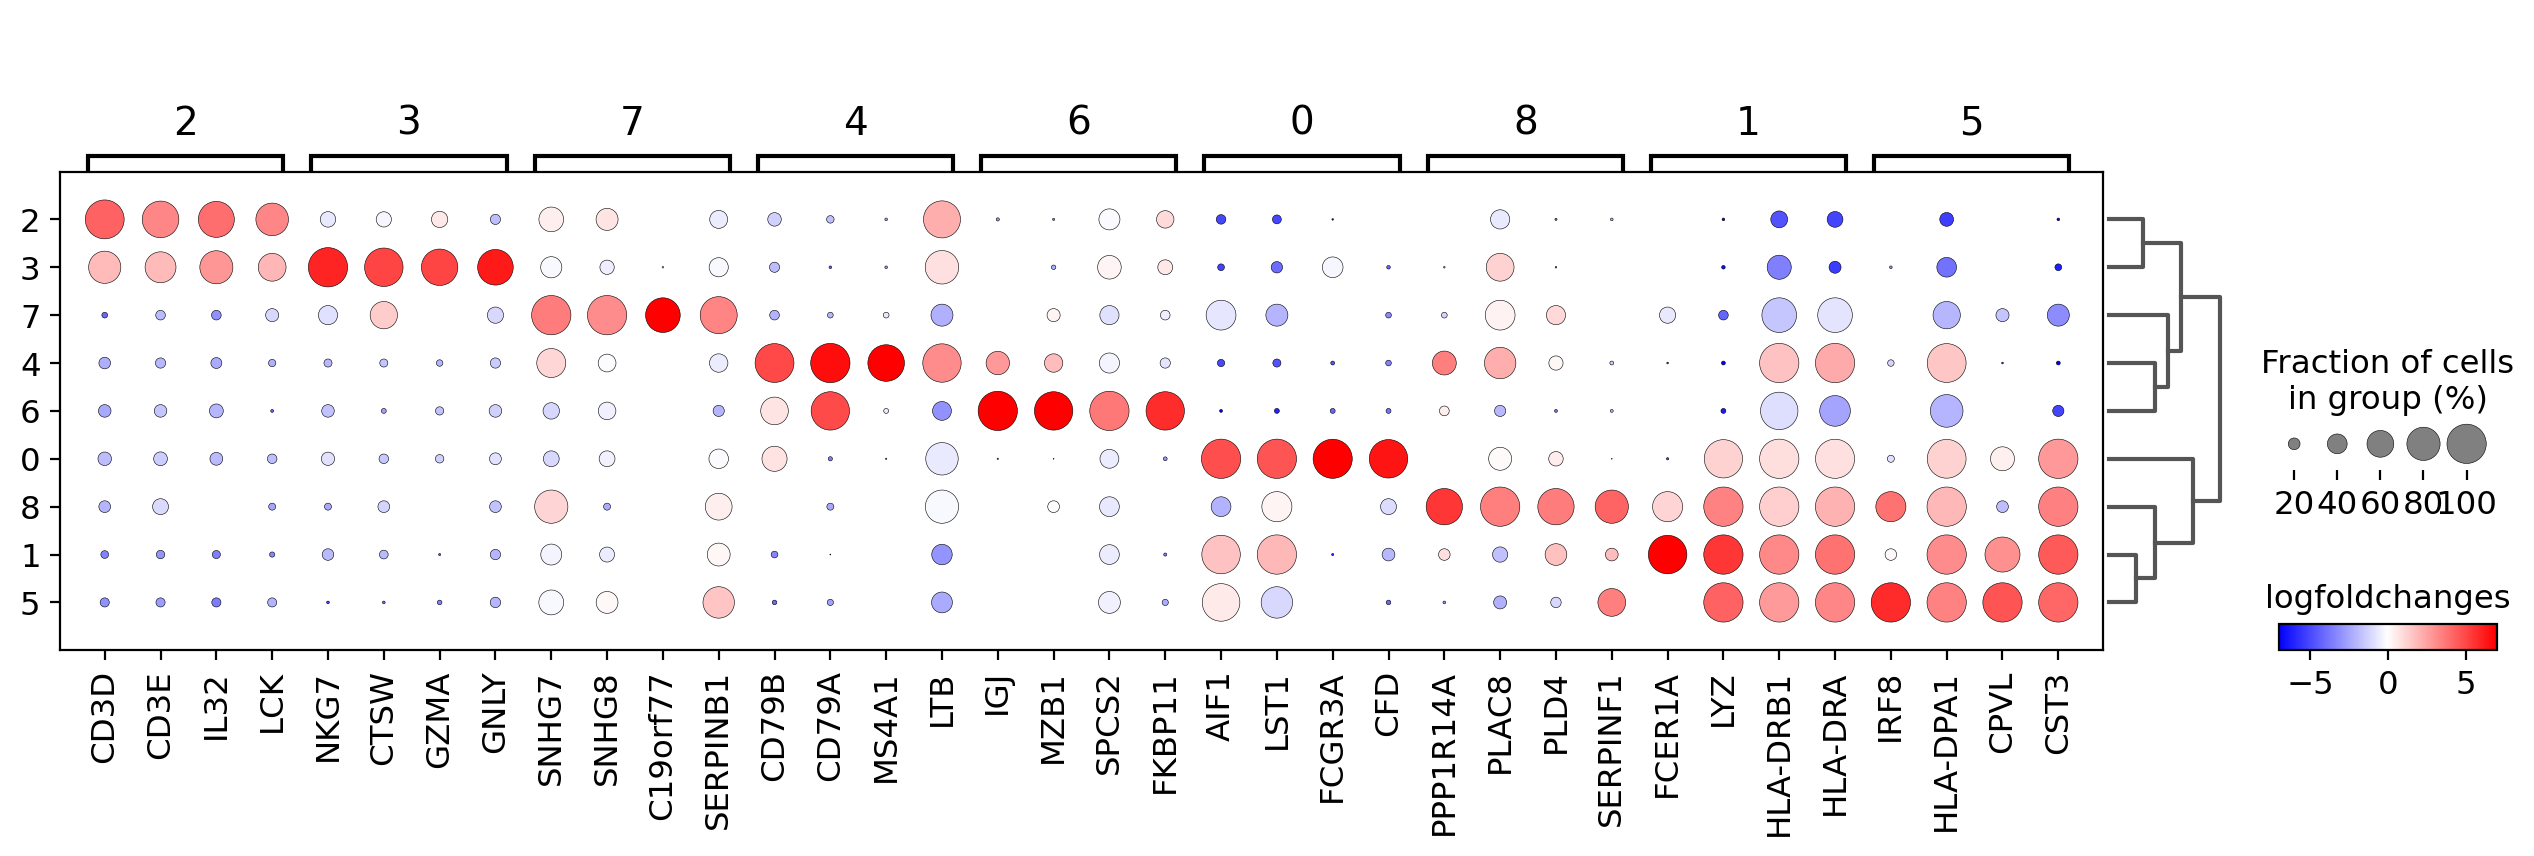

In [76]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

### Focusing on Particular Groups

We can focus on specific groups, change the minimum fold change threshold, and the number genes we may wanna see.

categories: 0, 1, 2, etc.
var_group_labels: 1, 5


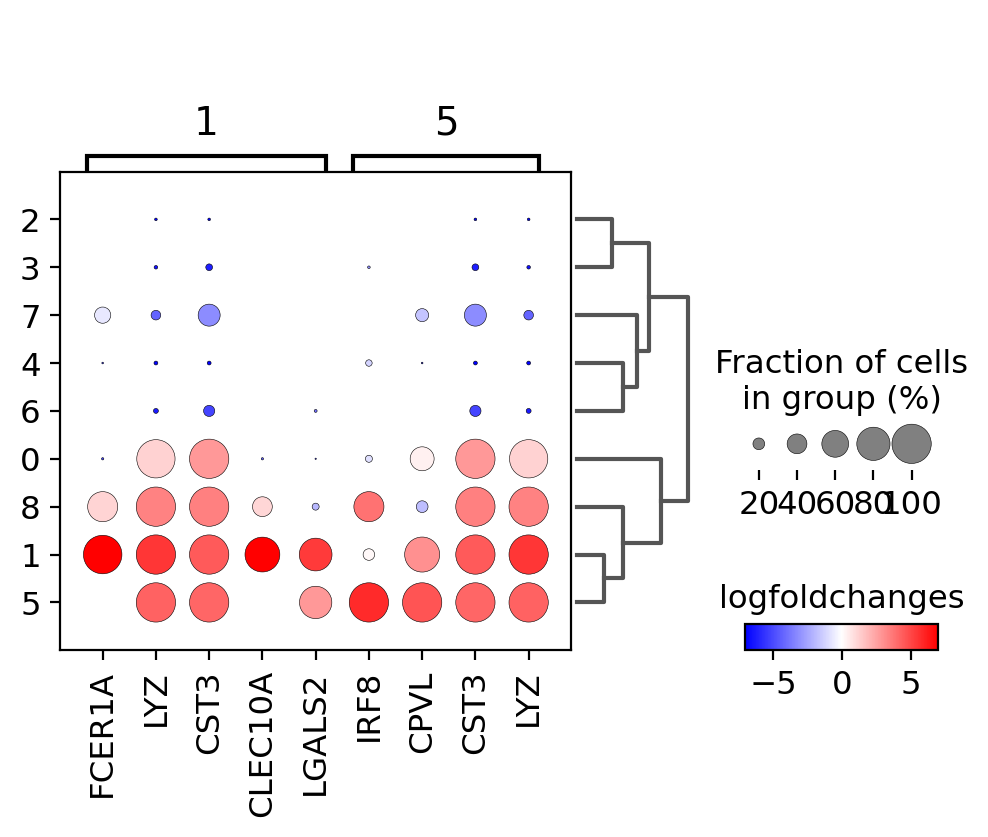

In [77]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=30, values_to_plot='logfoldchanges', min_logfoldchange=4, vmax=7, vmin=-7, cmap='bwr', groups=['1', '5'])

## Marker Genes in a Matrixplot

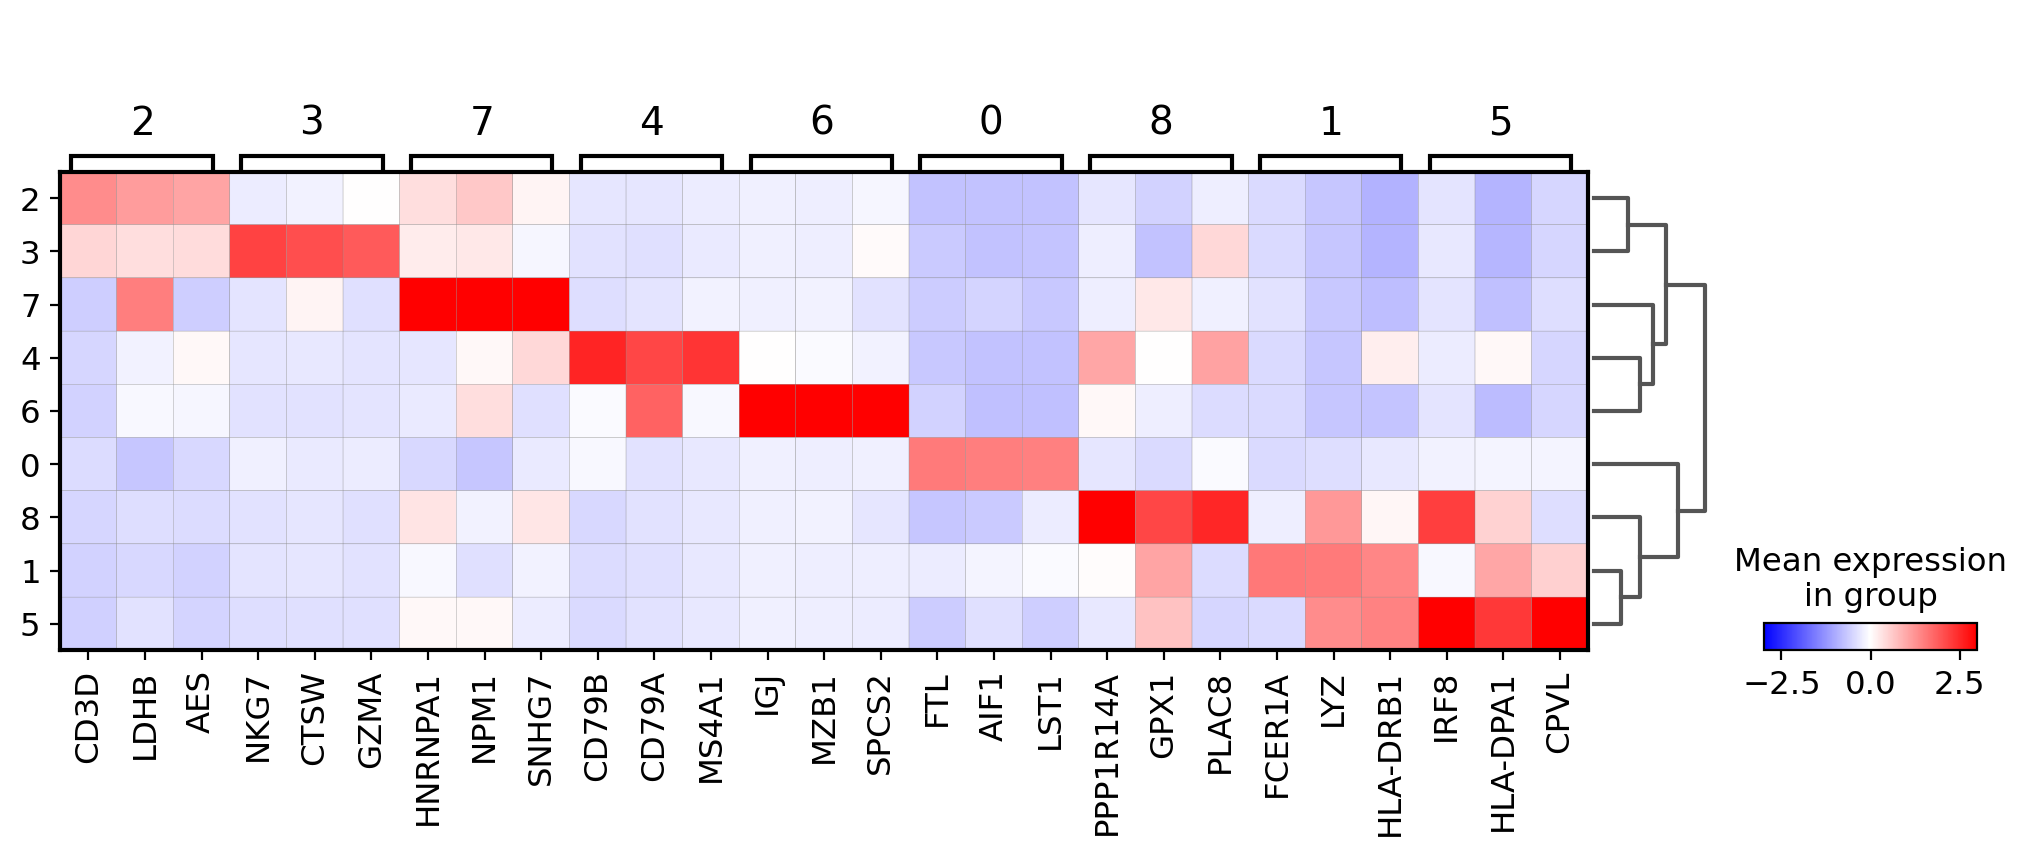

In [78]:
sc.pl.rank_genes_groups_matrixplot(pbmc, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap='bwr', layer='scaled')

## ... In Violin Plots

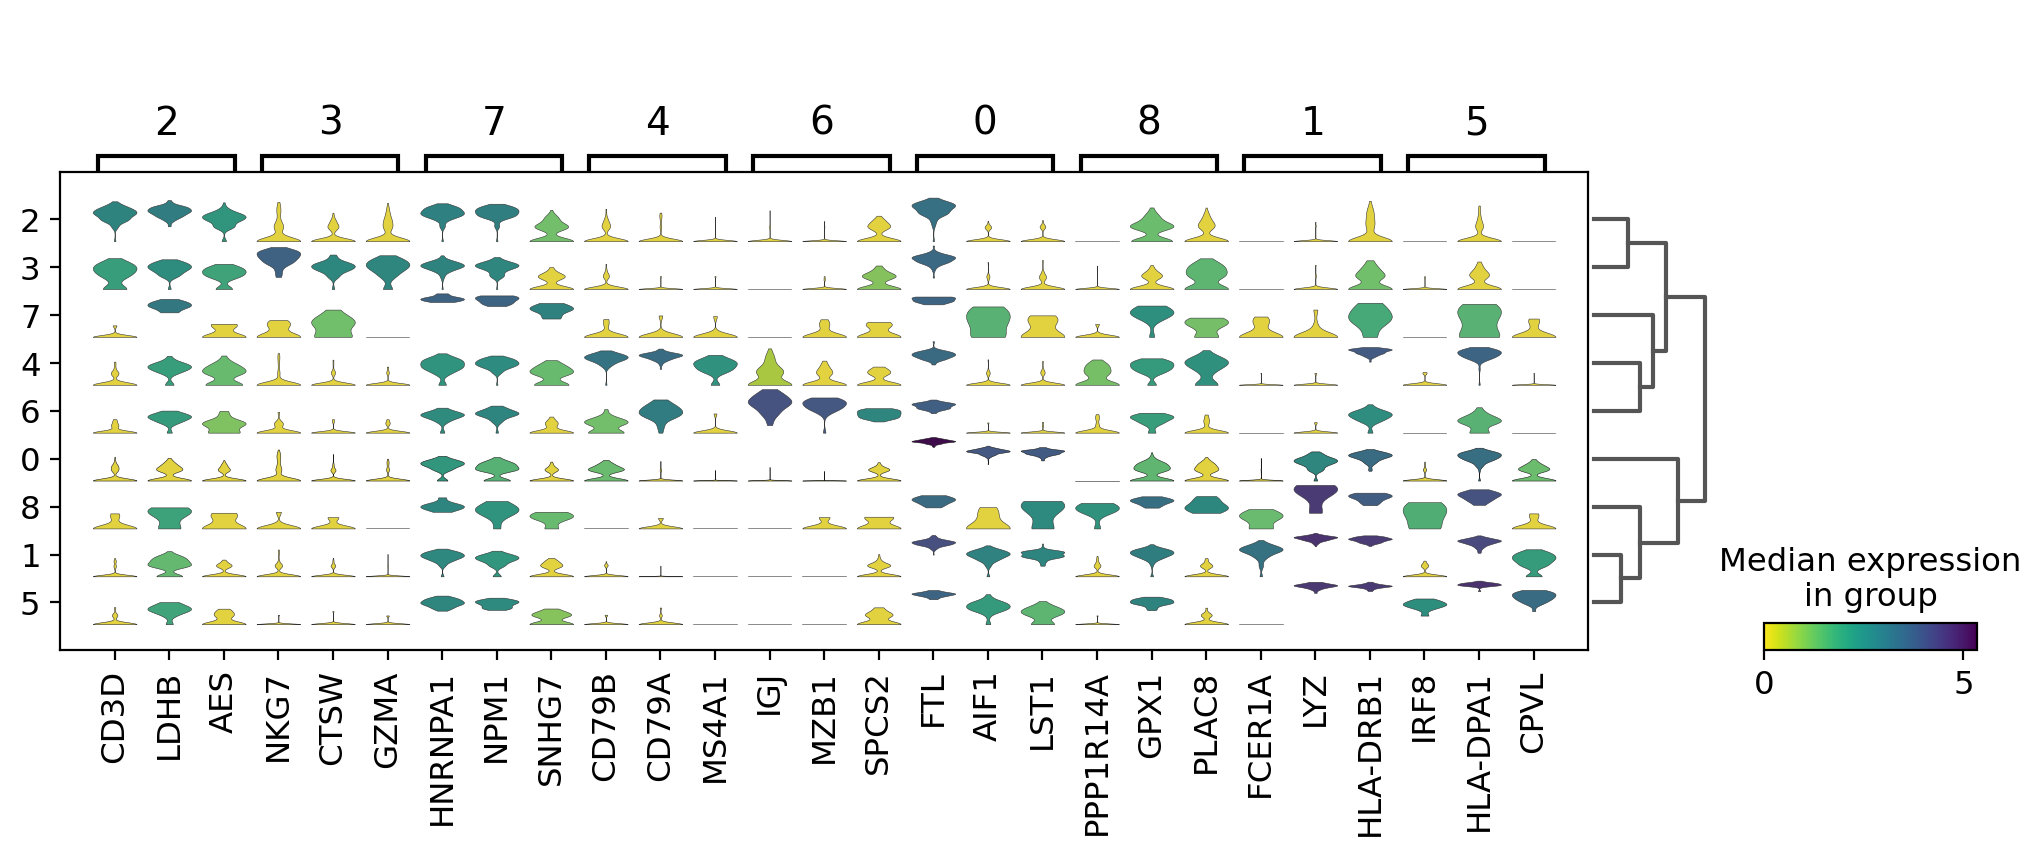

In [79]:
sc.pl.rank_genes_groups_stacked_violin(pbmc, n_genes=3, cmap='viridis_r')

## ... In a Heatmap

{'heatmap_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7efc8937a340>,
 'groupby_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7efc8ad954c0>,
 'dendrogram_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7efc8ad59100>,
 'gene_groups_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7efc8ad23550>}

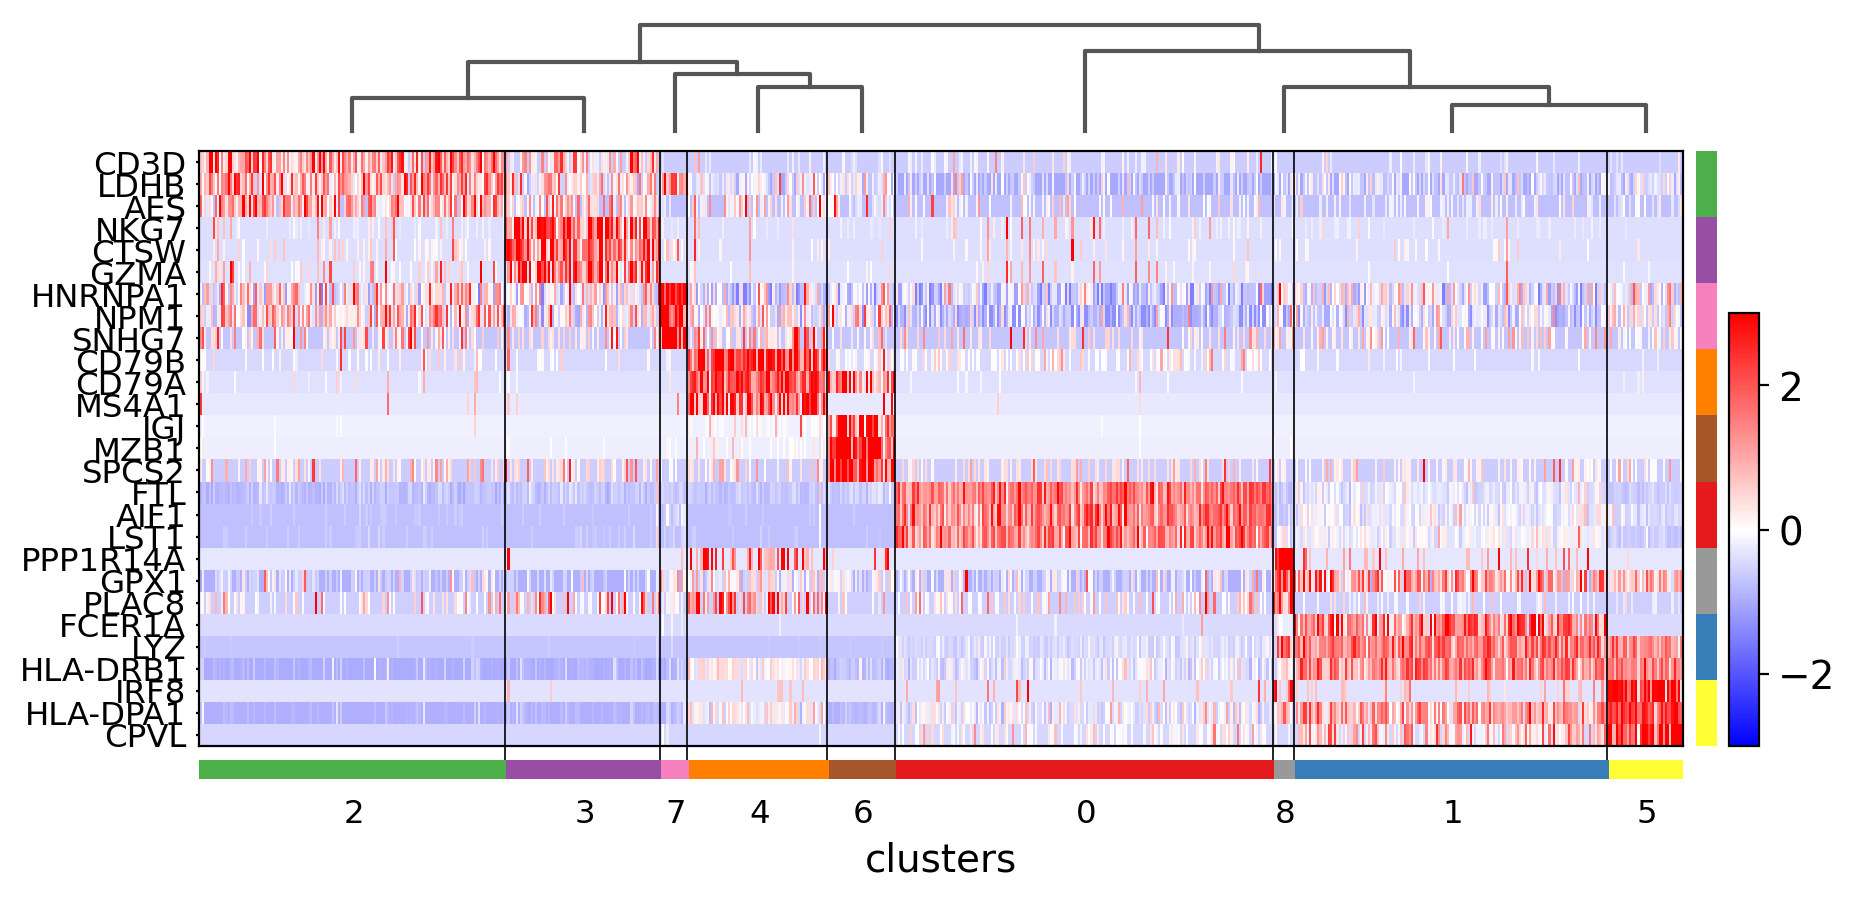

In [81]:
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, layer='scaled', cmap='bwr', figsize=(10,5), show=False)

Turn gene labels off. 

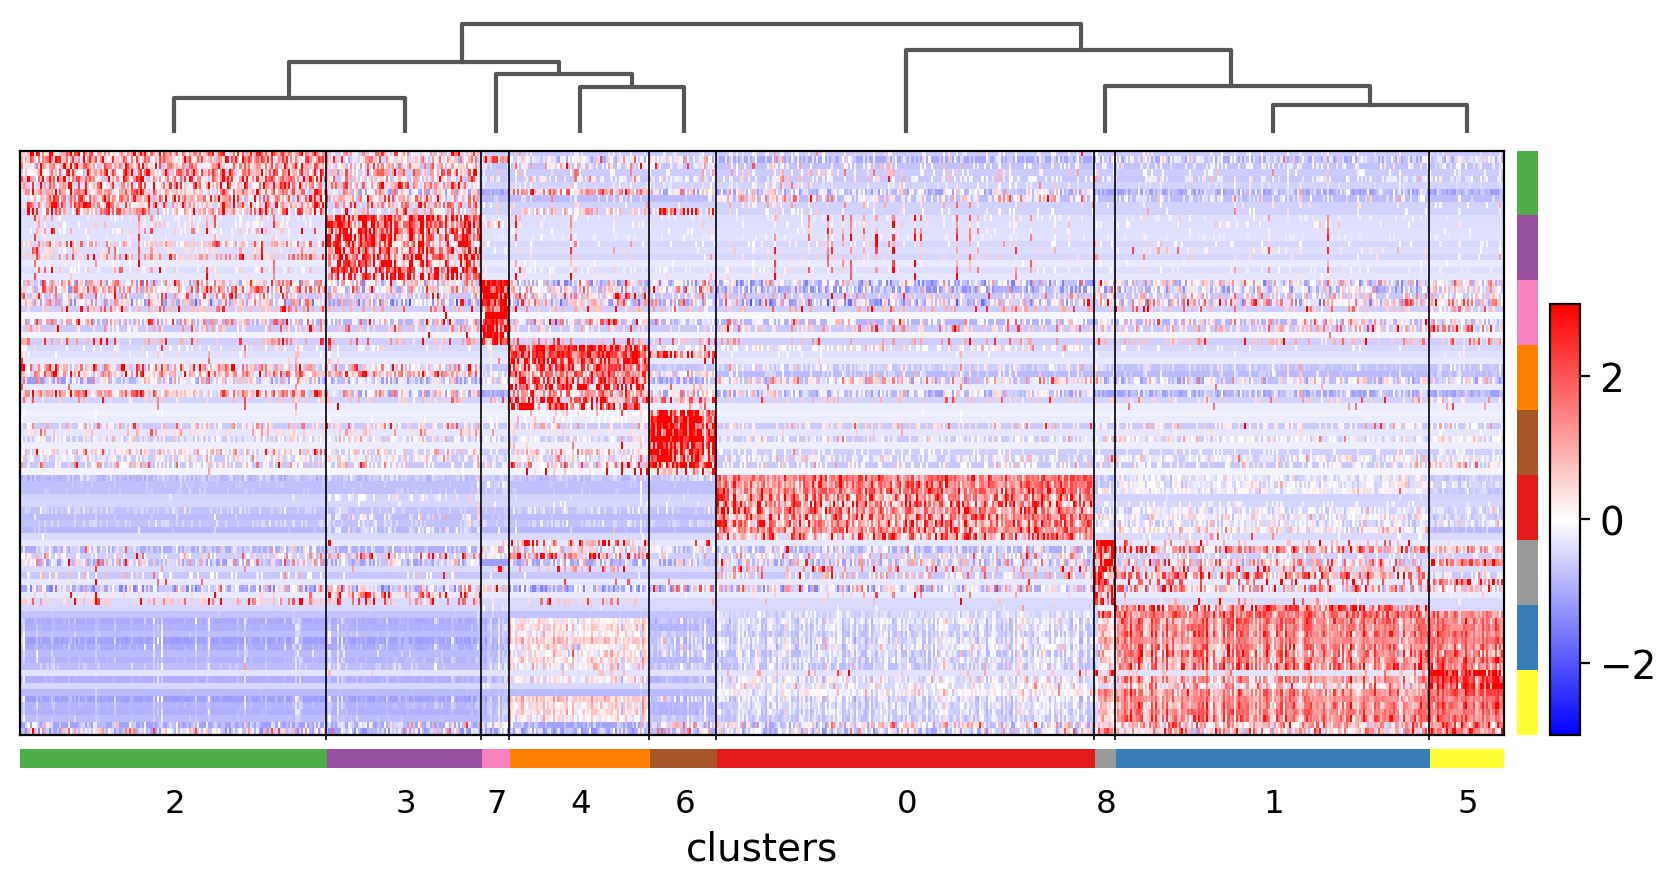

In [82]:
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=10, use_raw=False, swap_axes=True, show_gene_labels=False,
                                vmin=-3, vmax=3, cmap='bwr')

## ... In a Tracksplot

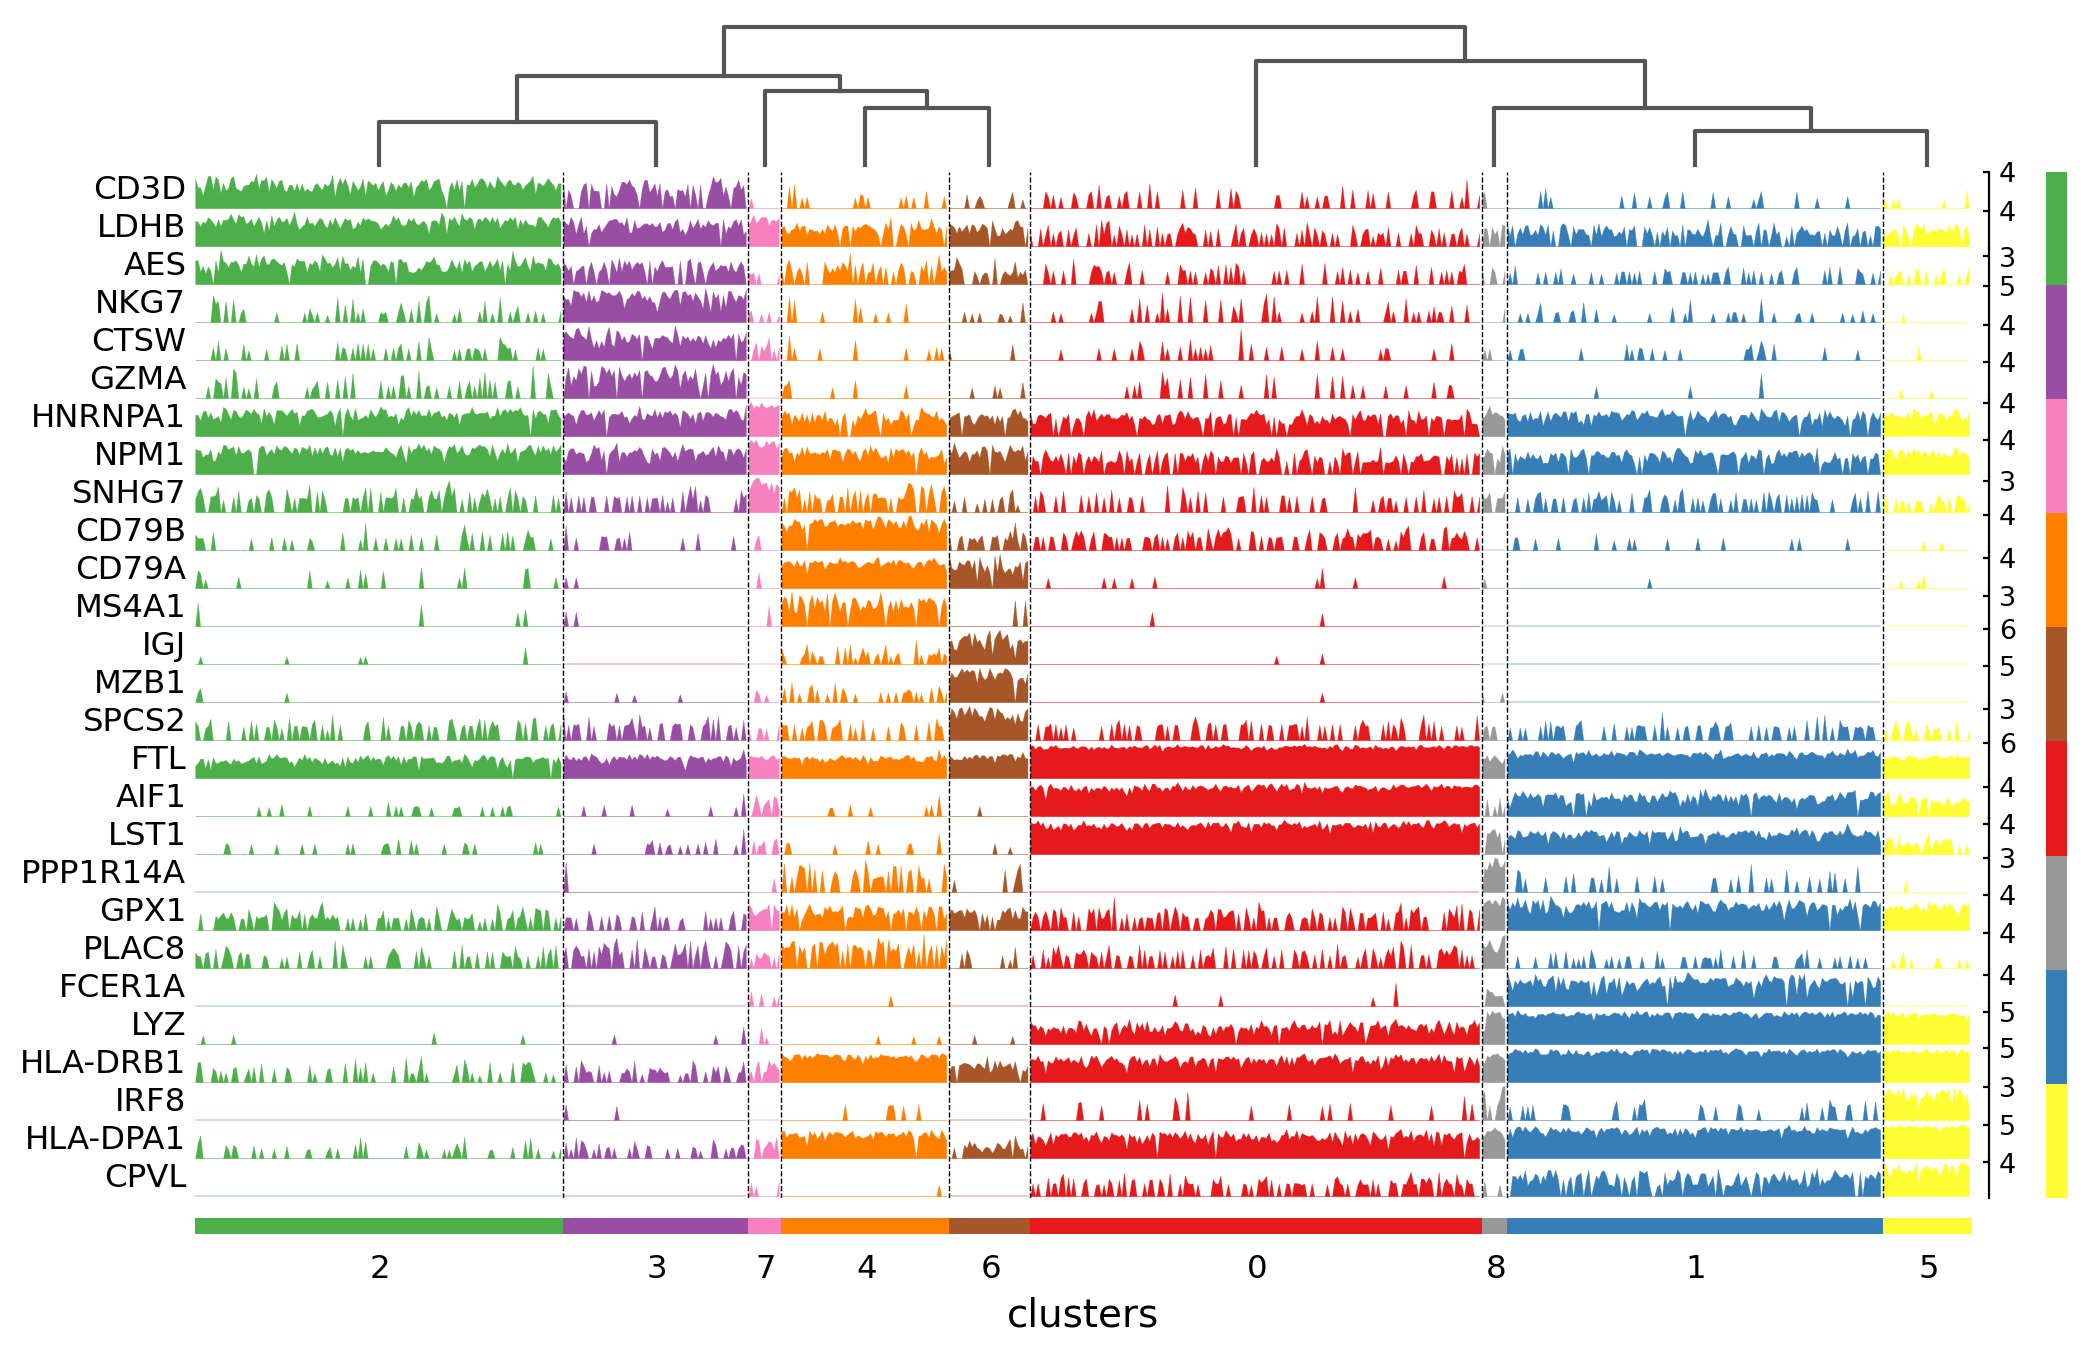

In [83]:
sc.pl.rank_genes_groups_tracksplot(pbmc, n_genes=3)

## Comparing Marker Genes with Split Violins

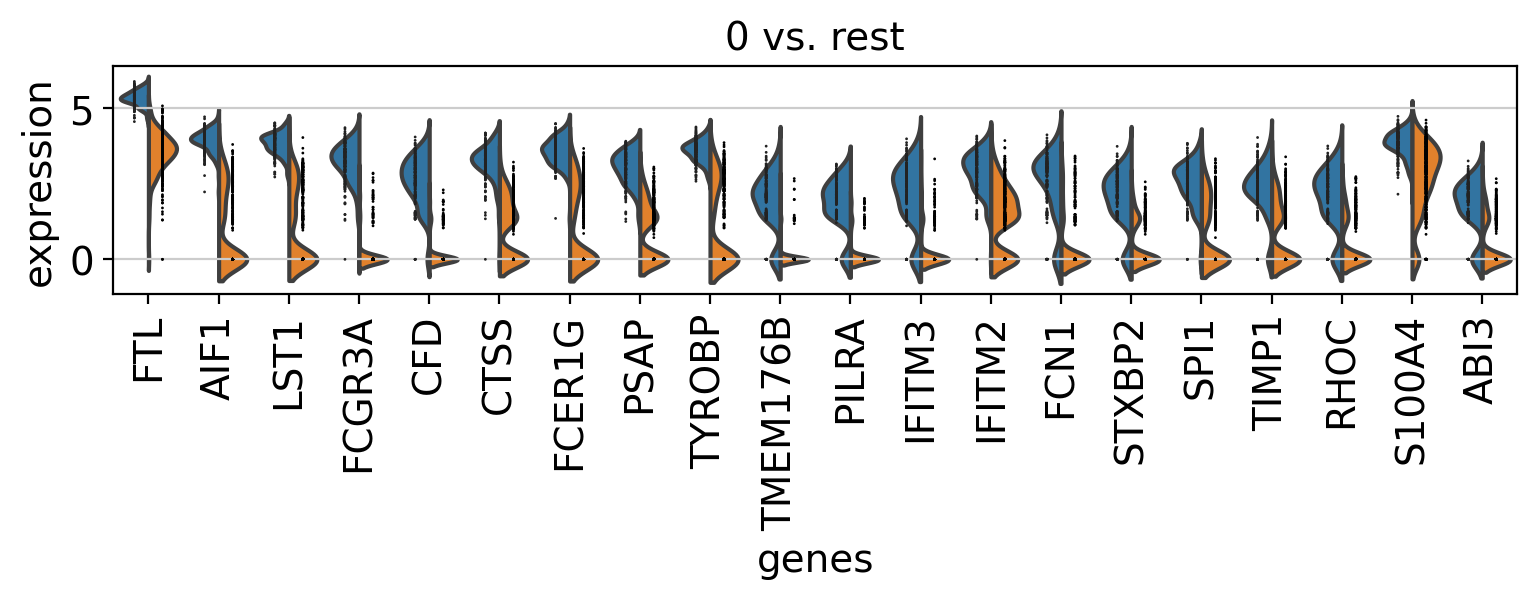

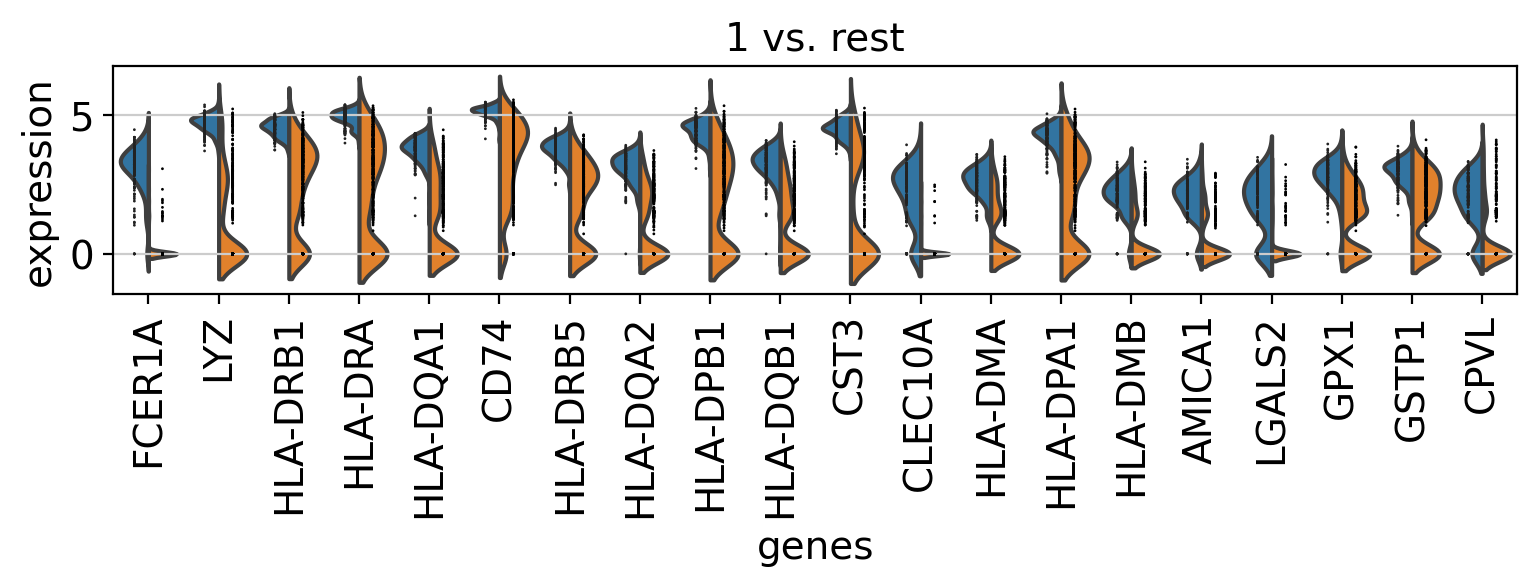

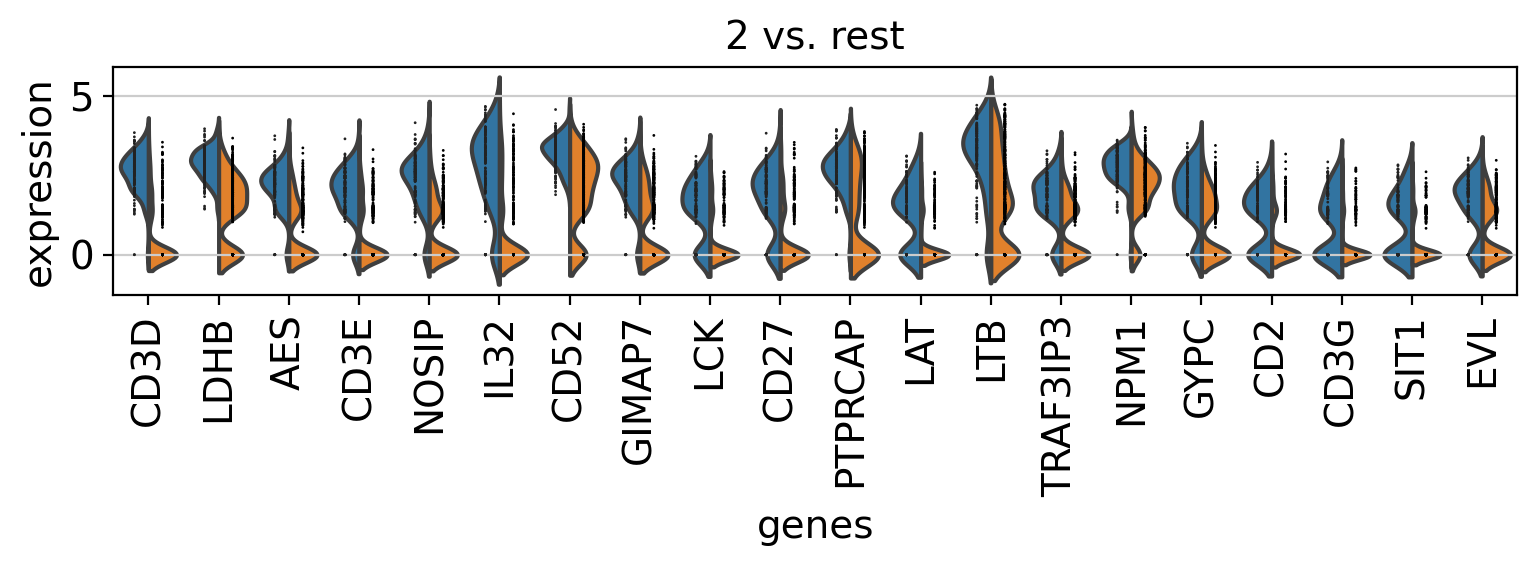

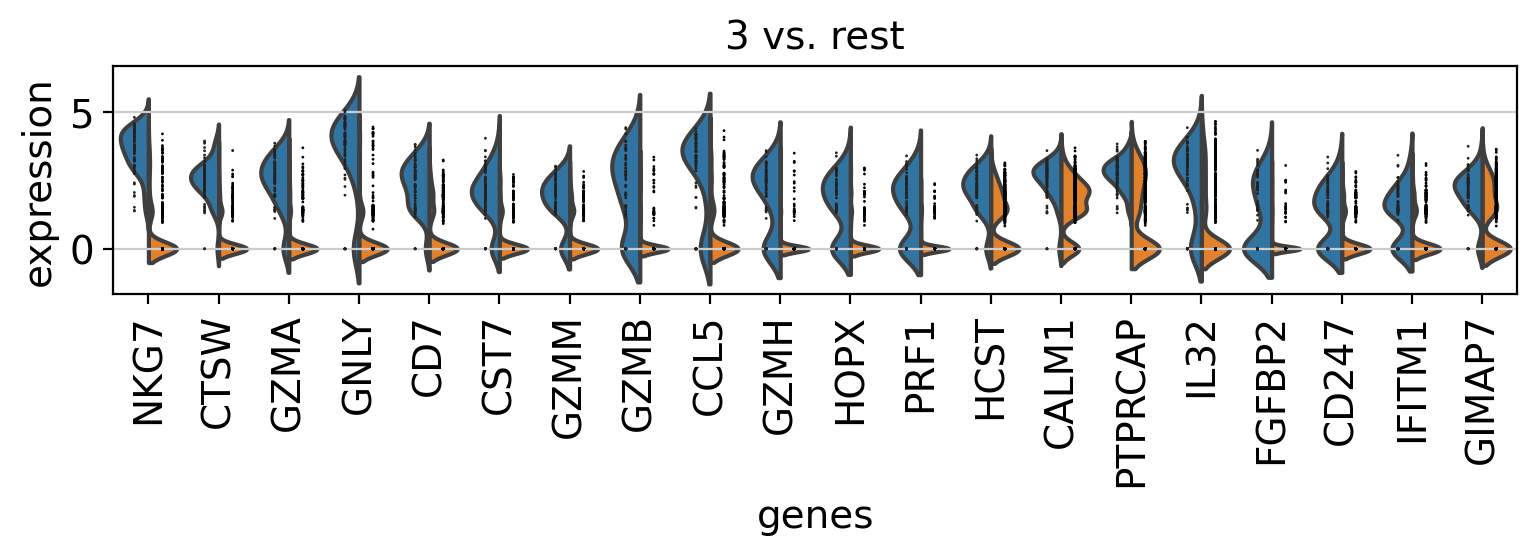

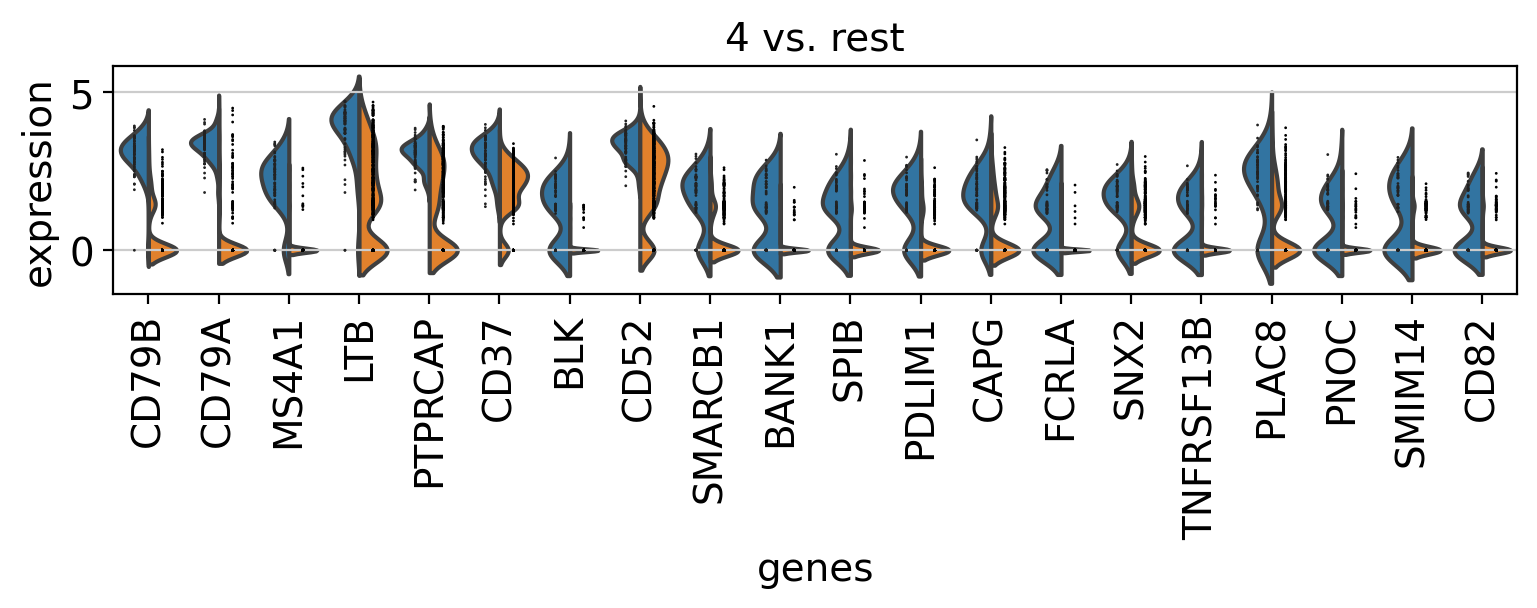

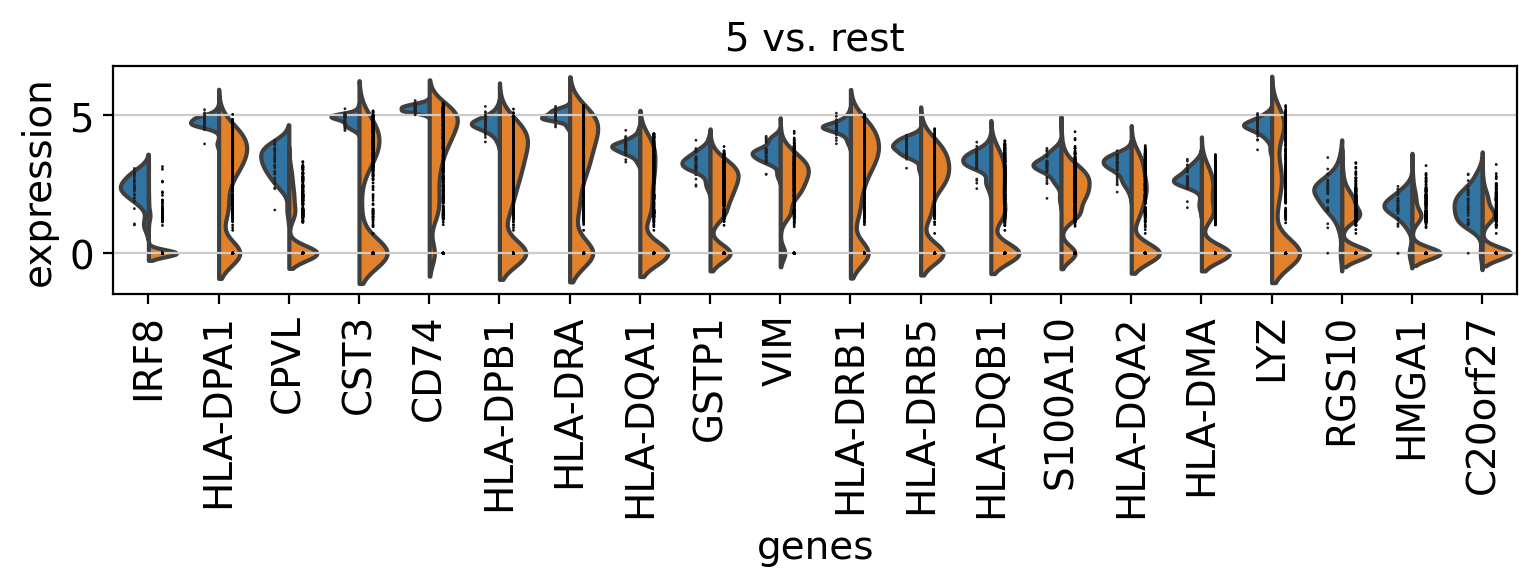

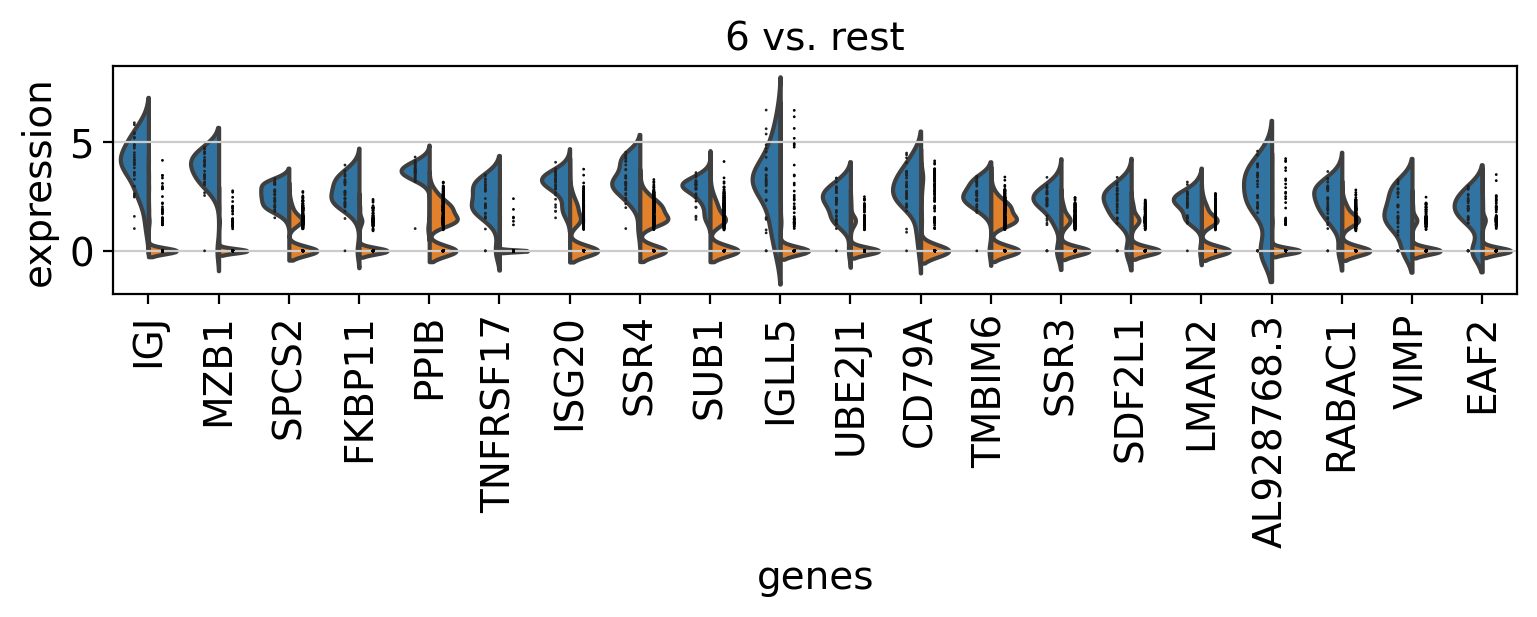

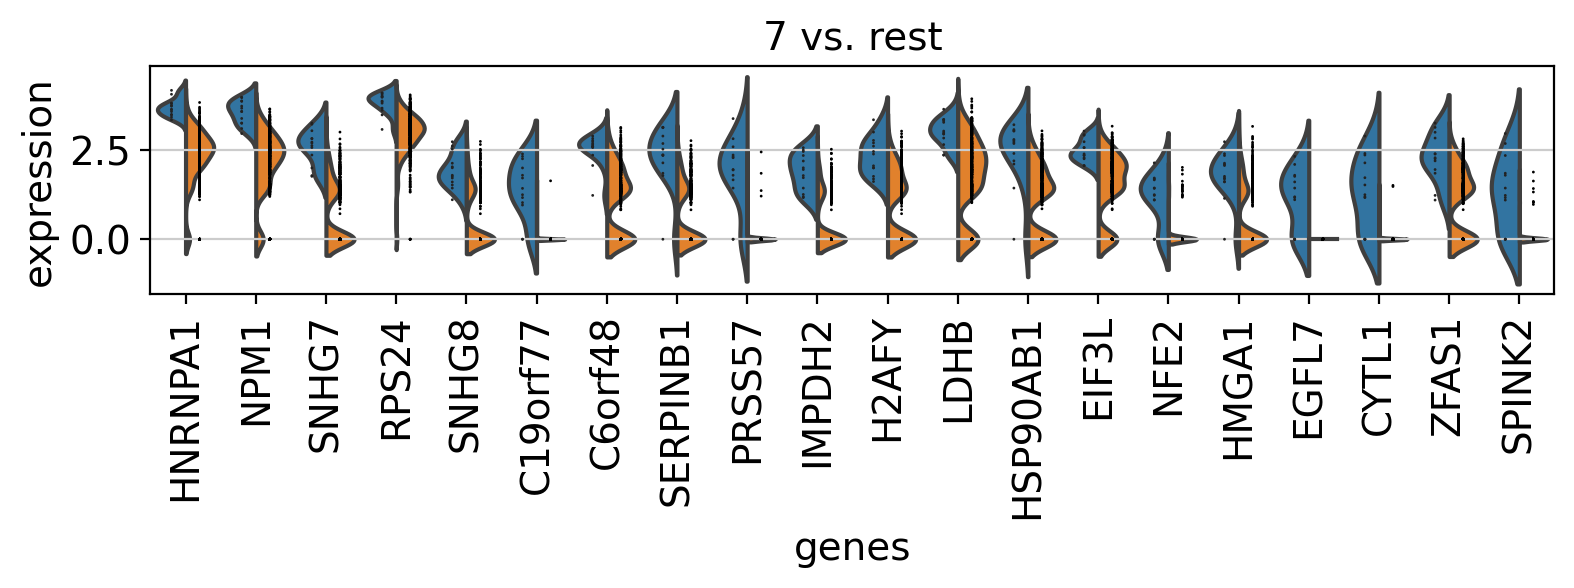

In [ ]:
rcParams['figure.figsize'] = 9,1.5
sc.pl.rank_genes_groups_violin(pbmc, n_genes=20, jitter=False)

## Exploring Some Dendrogram Options